In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from datetime import datetime
import time
import cpuinfo
import torch
import psutil
import random
import torch.nn as nn
import torch.optim as optim
import platform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, accuracy_score, roc_auc_score, precision_recall_curve, auc, f1_score, recall_score, precision_score, classification_report

SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

def get_memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 2)
    return mem

# print("=" * 40, "SYSTEM INFORMATION", "=" * 40)
# print(f"Operating System : {platform.system()} {platform.release()} ({platform.version()})")
# print(f"Architecture     : {platform.architecture()[0]}")
# print(f"Machine Type     : {platform.machine()}")
# cpu = cpuinfo.get_cpu_info()
# print(f"CPU Brand        : {cpu['brand_raw']}")
# print(f"Logical Cores    : {psutil.cpu_count(logical=True)}")
# print(f"Physical Cores   : {psutil.cpu_count(logical=False)}")
# print(f"CPU Frequency    : {psutil.cpu_freq().current:.2f} MHz")
# ram = psutil.virtual_memory()
# print(f"Total RAM        : {ram.total / 1e9:.2f} GB")
# print(f"Python Version   : {platform.python_version()}")
# print("=" * 40, "PYTORCH & GPU", "=" * 40)
# print(f"PyTorch Version  : {torch.__version__}")
# print(f"CUDA Available   : {torch.cuda.is_available()}")
# if torch.cuda.is_available():
#     print(f"CUDA Version     : {torch.version.cuda}")
#     print(f"cuDNN Version    : {torch.backends.cudnn.version()}")
#     print(f"GPU Count        : {torch.cuda.device_count()}")
#     for i in range(torch.cuda.device_count()):
#         print(f"GPU {i} Name      : {torch.cuda.get_device_name(i)}")
#         print(f"  Capability     : {torch.cuda.get_device_capability(i)}")
#         print(f"  Allocated Mem  : {torch.cuda.memory_allocated(i)/1e6:.2f} MB")
#         print(f"  Reserved Mem   : {torch.cuda.memory_reserved(i)/1e6:.2f} MB")
# else:
#     print("GPU              : Not Available")
# print("=" * 100)

# Model

In [138]:
class MODEL(nn.Module):
    def __init__(self):
        super(MODEL, self).__init__()
        self.C1 = nn.Conv1d(2, 16, 4)
        self.C2 = nn.Conv1d(16, 16, 4)
        self.C3 = nn.Conv1d(16, 16, 4)
        self.pool = nn.MaxPool1d(3)
        
        self.F1 = nn.Linear(16, 32)
        self.F2 = nn.Linear(32, 1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)
        self.attn_weights = nn.Parameter(torch.randn(78))

    def forward(self, x):
        attention = torch.matmul(x, self.attn_weights)
        attention = torch.sigmoid(attention).unsqueeze(1)
        y = (x * attention).unsqueeze(1)
        
        x = x.unsqueeze(1)
        x = torch.cat((x, y), dim=1)
        
        x = self.tanh(self.C1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.tanh(self.C2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.tanh(self.C3(x))
        x = self.pool(x)
        x = self.dropout(x).squeeze(2)
        x = self.tanh(self.F1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.F2(x)).squeeze(1)
        return x

# Test

In [139]:
def test(model, test_loader):
    start_time = time.time()
    all_predictions = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).cpu().numpy()
            preds = (outputs >= 0.5).astype(int)
            all_predictions.extend(preds if preds.ndim == 1 else preds.tolist())
            all_labels.extend(y_batch.cpu().numpy().tolist())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    elapsed_time = time.time() - start_time

    M = "OK-"
    if len(set(all_predictions)) == 1:
        M = "ER-"
        
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)
    aupr = average_precision_score(all_labels, all_predictions)
    Far = fp / (fp + tn) if (fp + tn) != 0 else 0
    
    print(classification_report(all_labels, all_predictions, digits=5))
    errors = [(i, p, l) for i, (p, l) in enumerate(zip(all_predictions, all_labels)) if p != l]
    print(f"Total Errors: {len(errors)}")
    for i, pred, label in errors[:5]:
        print(f"Index: {i}, Predicted: {pred}, Actual: {label}")
    memory_usage = get_memory_usage()
    return f"{M} Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}, ROC AUC: {roc_auc:.5f}, AUPR (PR-AUC): {aupr:.5f}, Sensitivity: {sensitivity:.5f}, Specificity: {specificity:.5f}, Far: {Far}, False Positive Rate (FPR): {false_positive_rate:.5f}, False Negative Rate (FNR): {false_negative_rate:.5f}, Runtime: {elapsed_time:.3f} sec , Memory Usage: {memory_usage:.2f} MB"


# Train

In [140]:
def train(model, criterion, optimizer, scheduler, epochs, train_loader, val_loader, test_loader):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs_train = model(X_train_batch)
            loss_train = criterion(outputs_train, y_train_batch.float())
            loss_train.backward()
            optimizer.step()
            scheduler.step()
            
            if (batch_idx + 1) % 10 == 0:
                model.eval()
                with torch.no_grad():
                    val_loss_batch = 0
                    for X_val_batch, y_val_batch in val_loader:
                        outputs_val = model(X_val_batch)
                        loss_val = criterion(outputs_val, y_val_batch.float())
                        val_loss_batch += loss_val.item()
                    train_loss_batch = 0
                    for X_train_batch, y_train_batch in train_loader:
                        outputs_train = model(X_train_batch)
                        loss_train = criterion(outputs_train, y_train_batch.float())
                        train_loss_batch += loss_train.item()
                        
                    val_loss_avg = val_loss_batch / len(val_loader)
                    train_loss_avg = train_loss_batch / len(train_loader)
                
                for param_group in optimizer.param_groups:
                    lrnum = param_group['lr']
                train_losses.append(train_loss_avg)
                val_losses.append(val_loss_avg)
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Train Loss: {loss_train.item():.4f}, Val Loss: {val_loss_avg:.4f}, LR: {lrnum:.10f}')
                model.train()
        
        if test_loader and epoch % 10 == 0:
            RES = test(model, test_loader)
            print(f"Epoch {epoch+1}: {RES}")

    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.legend()
    plt.savefig('loss.pdf')
    plt.close()

# Dataset

In [141]:
def CONVERT(df):
    X = df.drop(' Label', axis=1)
    y = df[' Label']
    X.columns = X.columns.str.strip()
    important_features = ['Bwd Packet Length Std', 'Average Packet Size', 'Flow Duration', 'Flow IAT Std']
    important_df = X[important_features] * 2.0
    remaining_df = X.drop(columns=important_features)
    X = pd.concat([remaining_df, important_df], axis=1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    return X, y

=========== D: cpu ===========

 Label
1    5675
0    4325
Name: count, dtype: int64


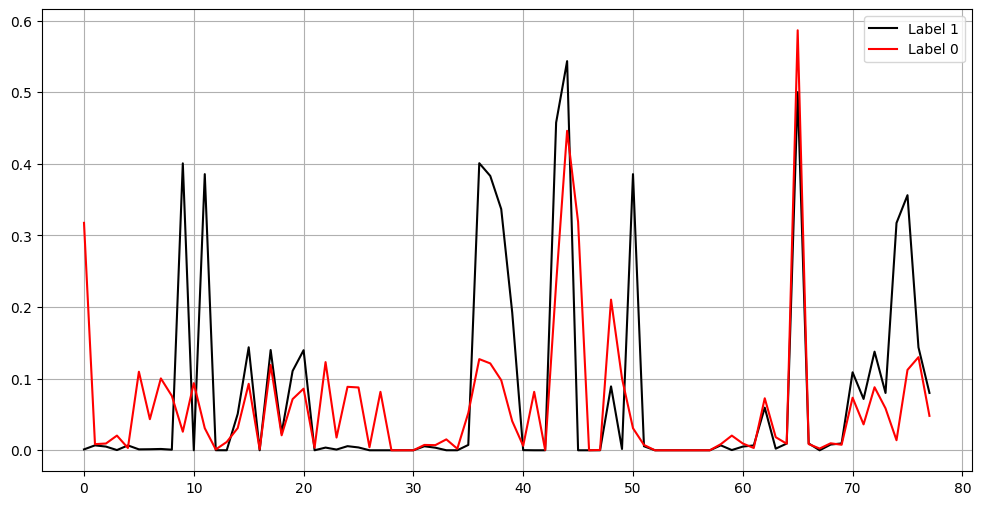

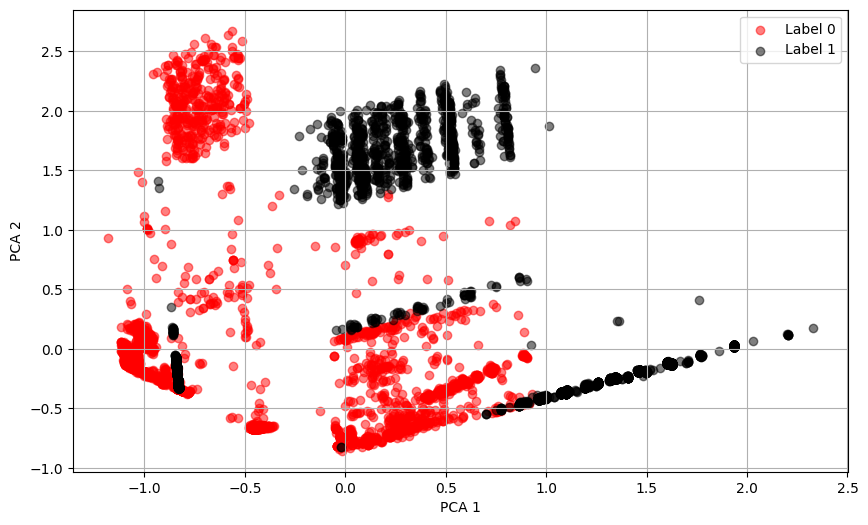

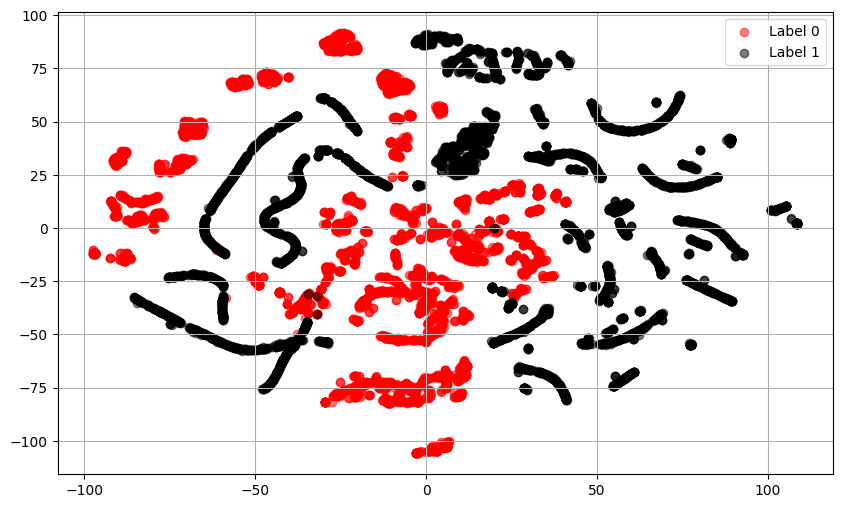

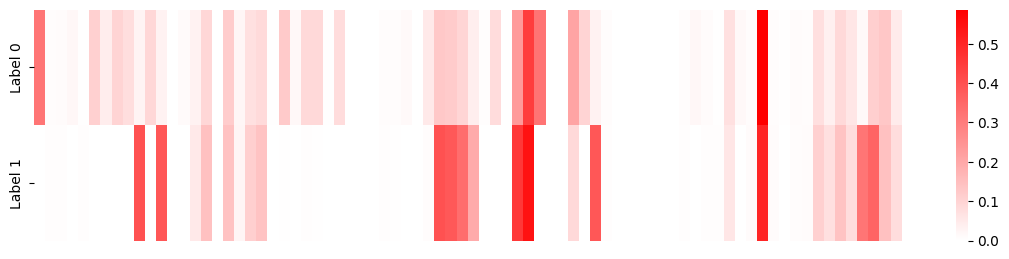

In [142]:
train_loader, val_loader, test_loader = None, None, None
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'=========== D: {device} ===========\n')
current_dir = "Data/"
df = pd.read_csv(os.path.join(current_dir, 'DDos.csv'))
encoder = LabelEncoder()
df[' Label'] = encoder.fit_transform(df[' Label'])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.astype(int)
df = df.sample(n=10000, random_state=28, replace=False)
X, y = CONVERT(df)
print(y.value_counts())
X_array = np.array(X)
y_array = np.array(y)
X_class1 = X_array[y_array == 1]
X_class0 = X_array[y_array == 0]
mean1 = X_class1.mean(axis=0)
mean0 = X_class0.mean(axis=0)
mean_features = np.vstack([X_class0.mean(axis=0), X_class1.mean(axis=0)])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_array)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_array)
plt.figure(figsize=(12, 6))
plt.plot(mean1, color='black', label='Label 1')
plt.plot(mean0, color='red', label='Label 0')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y_array==0, 0], X_pca[y_array==0, 1], color='red', alpha=0.5, label='Label 0')
plt.scatter(X_pca[y_array==1, 0], X_pca[y_array==1, 1], color='black', alpha=0.5, label='Label 1')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[y_array==0, 0], X_tsne[y_array==0, 1], color='red', alpha=0.5, label='Label 0')
plt.scatter(X_tsne[y_array==1, 0], X_tsne[y_array==1, 1], color='black', alpha=0.5, label='Label 1')
plt.legend()
plt.grid(True)
plt.show()
cmap = LinearSegmentedColormap.from_list("c", ["white", "red"])
plt.figure(figsize=(14, 3))
sns.heatmap(mean_features, cmap=cmap, annot=False, xticklabels=False, yticklabels=["Label 0", "Label 1"])
plt.show()

In [143]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Run

In [144]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 500
SL = len(train_loader) * epochs
model = MODEL().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SL, eta_min=1e-5)

total_params = sum(p.numel() for p in model.parameters())
print(f"=========== TP: {total_params:,} ===========")

train(model, criterion, optimizer, scheduler, epochs, train_loader, val_loader, test_loader)
RES = test(model, test_loader)
print(RES)

=========== TP: 2,879 ===========
Epoch [1/500], Batch [10/110], Train Loss: 0.6807, Val Loss: 0.6846, LR: 0.0009999999
Epoch [1/500], Batch [20/110], Train Loss: 0.6962, Val Loss: 0.6697, LR: 0.0009999997
Epoch [1/500], Batch [30/110], Train Loss: 0.6599, Val Loss: 0.6580, LR: 0.0009999993
Epoch [1/500], Batch [40/110], Train Loss: 0.6330, Val Loss: 0.6360, LR: 0.0009999987
Epoch [1/500], Batch [50/110], Train Loss: 0.5584, Val Loss: 0.5982, LR: 0.0009999980
Epoch [1/500], Batch [60/110], Train Loss: 0.4633, Val Loss: 0.5441, LR: 0.0009999971
Epoch [1/500], Batch [70/110], Train Loss: 0.5050, Val Loss: 0.4870, LR: 0.0009999960
Epoch [1/500], Batch [80/110], Train Loss: 0.4498, Val Loss: 0.4191, LR: 0.0009999948
Epoch [1/500], Batch [90/110], Train Loss: 0.3367, Val Loss: 0.3353, LR: 0.0009999935
Epoch [1/500], Batch [100/110], Train Loss: 0.2124, Val Loss: 0.2483, LR: 0.0009999919
Epoch [1/500], Batch [110/110], Train Loss: 0.2884, Val Loss: 0.1754, LR: 0.0009999902
Confusion Matrix:


In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEEDlist = [28, 7, 1234, 2025]
for i, SEED in enumerate(SEEDlist):
    train_loader, val_loader, test_loader = None, None, None
    print(f"=========== SEED: {SEED} , FOLD: {i+1}/{len(SEEDlist)}, D: {device} ===========")
    random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    current_dir = "Data/"
    df = pd.read_csv(os.path.join(current_dir, 'DDos.csv'))
    encoder = LabelEncoder()
    df[' Label'] = encoder.fit_transform(df[' Label'])
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    df = df.astype(int)
    df = df.sample(n=10000, random_state=SEED, replace=False)
    X = df.drop(' Label', axis=1)
    y = df[' Label']
    X.columns = X.columns.str.strip()
    important_features = ['Bwd Packet Length Std', 'Average Packet Size', 'Flow Duration', 'Flow IAT Std']
    important_df = X[important_features] * 2.0
    remaining_df = X.drop(columns=important_features)
    X = pd.concat([remaining_df, important_df], axis=1)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    print(y.value_counts())
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    epochs = 500
    SL = len(train_loader) * epochs
    model = MODEL().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=SL, eta_min=1e-5)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"=========== TP: {total_params:,} ===========")
    train(model, criterion, optimizer, scheduler, epochs, train_loader, val_loader, test_loader)
    RES = test(model, test_loader)
    print(RES)

=========== SEED: 28 , FOLD: 1/4, D: cpu ===========
 Label
1    5675
0    4325
Name: count, dtype: int64
=========== TP: 2,879 ===========
Epoch [1/500], Batch [10/110], Train Loss: 0.7080, Val Loss: 0.6806, LR: 0.0009999999
Epoch [1/500], Batch [20/110], Train Loss: 0.6097, Val Loss: 0.6747, LR: 0.0009999997
Epoch [1/500], Batch [30/110], Train Loss: 0.6234, Val Loss: 0.6648, LR: 0.0009999993
Epoch [1/500], Batch [40/110], Train Loss: 0.6848, Val Loss: 0.6483, LR: 0.0009999987
Epoch [1/500], Batch [50/110], Train Loss: 0.6563, Val Loss: 0.6167, LR: 0.0009999980
Epoch [1/500], Batch [60/110], Train Loss: 0.5491, Val Loss: 0.5572, LR: 0.0009999971
Epoch [1/500], Batch [70/110], Train Loss: 0.4208, Val Loss: 0.4740, LR: 0.0009999960
Epoch [1/500], Batch [80/110], Train Loss: 0.4427, Val Loss: 0.3834, LR: 0.0009999948
Epoch [1/500], Batch [90/110], Train Loss: 0.3122, Val Loss: 0.2946, LR: 0.0009999935
Epoch [1/500], Batch [100/110], Train Loss: 0.1351, Val Loss: 0.2197, LR: 0.0009999919